# Simulate force profiles for CaF

In [1]:
# Import the packages required for the notebook
using
    Revise,
    QuantumStates,
    OpticalBlochEquations,
    UnitsToValue

using DifferentialEquations: solve, ODEProblem, PeriodicCallback, DP5

# A few constants used for the simulation
λ = 606e-9
Γ = 2π * 8.3e6 # in units of MHz
m = @with_unit 57 "u"
k = 2π / λ

# Create a few functions to perform random sampling of position and direction
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Load $\tilde{X}(000)$ and $\tilde{A}(000)$ Hamiltonians


In [7]:
HX = load_from_file("CaF_v0_N0to3_Hamiltonian", "G:\\My Drive\\github\\QuantumStates\\Hamiltonians\\CaF\\")
HA = load_from_file("CaF_A_v0_J12to52_Hamiltonian", "G:\\My Drive\\github\\QuantumStates\\Hamiltonians\\CaF\\")

# Add Zeeman term to the X state Hamiltonian
const _μB = (μ_B / h) * (1e-6 * 1e-4)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
HX = add_to_H(HX, :B_z, gS * _μB * Zeeman_z)
HX.parameters.B_z = 1e-6

full_evaluate!(HX); QuantumStates.solve!(HX)
full_evaluate!(HA); QuantumStates.solve!(HA)

HA_J12_pos_parity_states = HA.states[5:8]

# Convert A states from Hund's case (a) to case (b) 
# We'll use the bending mode Hamiltonian for CaOH which has all basis states needed for the conversion
HX_0110 = load_from_file("CaOH_BendingMode_Hamiltonian", "G:\\My Drive\\github\\QuantumStates\\Hamiltonians\\CaOH\\")
states_A_J12_caseB = convert_basis(HA_J12_pos_parity_states, HX_0110.basis)
basis_idxs, reduced_A_J12_caseB_basis = states_to_basis(states_A_J12_caseB)
full_basis = [HX.basis; reduced_A_J12_caseB_basis]

for i ∈ eachindex(states_A_J12_caseB)
    states_A_J12_caseB[i].coeffs = states_A_J12_caseB[i].coeffs[basis_idxs]
    states_A_J12_caseB[i].basis = reduced_A_J12_caseB_basis
end

states = [HX.states[5:16]; states_A_J12_caseB]
for state ∈ states
    state.E *= 1e6
end

d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)
basis_tdms = get_tdms_two_bases(HX.basis, reduced_A_J12_caseB_basis, TDM)
tdms_between_states!(d_ge, basis_tdms, HX.states[5:16], states_A_J12_caseB)
d[1:12, 13:16, :] .= d_ge
;

## Set parameters

In [8]:
# Laser parameters
X_energy = energy(states[1])
A_energy = energy(states[13])

Isat = π * h * c * Γ / (3λ^3) * 1e-1 # in mW/cm^2
;

In [9]:
s = 340 / Isat
det = Γ

ω = 2π * (A_energy - X_energy) + det
pol_J12 = σ⁺
pol_J32 = σ⁻

ϵ(ϵ1) = t -> ϵ1

ϵ1 = ϵ(rotate_pol(pol_J12, -x̂)); laser1 = Field(+x̂, ϵ1, ω, s/6)
ϵ2 = ϵ(rotate_pol(pol_J12, +x̂)); laser2 = Field(-x̂, ϵ2, ω, s/6)
ϵ3 = ϵ(rotate_pol(pol_J12, -ŷ)); laser3 = Field(+ŷ, ϵ3, ω, s/6)
ϵ4 = ϵ(rotate_pol(pol_J12, +ŷ)); laser4 = Field(-ŷ, ϵ4, ω, s/6)
ϵ5 = ϵ(rotate_pol(pol_J12, -ẑ)); laser5 = Field(+ẑ, ϵ5, ω, s/6)
ϵ6 = ϵ(rotate_pol(pol_J12, +ẑ)); laser6 = Field(-ẑ, ϵ6, ω, s/6)

lasers_1D = [laser5, laser6]
lasers_3D = [laser1, laser2, laser3, laser4, laser5, laser6]

lasers = [lasers_3D...]
;

In [10]:
# Set initial conditions
particle = Particle()

ρ0 = zeros(ComplexF64, length(states), length(states)) # Use a static array for this??? Might be better...
ρ0[1,1] = 1.0

extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge)
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

p.r0 = (0.0, 0.0, 0.0) .* 2π
p.v = (0., 0., +0.5) #./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

In [11]:
# using BenchmarkTools
# dρ = deepcopy(p.ρ0_vec)
# @time ρ!(dρ, p.ρ0_vec, p, 0.0)
# @btime ρ!($dρ, $p.ρ0_vec, $p, 0.0)

In [12]:
t_end = 10p.period+1
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [15]:
prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)
@time sol = solve(prob, DP5(), callback=cb, abstol=1e-6)
;

  3.182592 seconds (210.66 k allocations: 765.676 MiB, 3.23% gc time)


In [16]:
sol.t[end], t_end

(3769.9111843077517, 6284.185307179587)

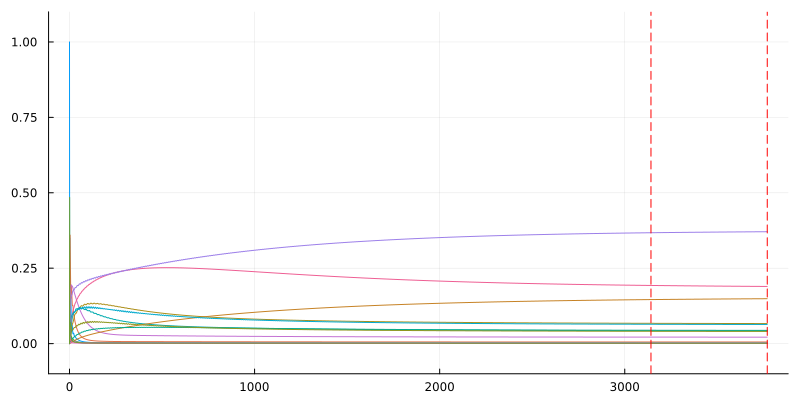

In [17]:
using Plots
plot_us = sol.u[1:10:end]
plot_ts = sol.t[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [18]:
prob.p.force_last_period * (1e-3 * ħ * k * Γ / m)

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -0.00035035153881680123
 -0.0001394862532440335
 -0.1257884840414075

## Force versus velocity

In [19]:
function prob_func!(prob, scan_values, i)
    # Update velocity and position
    prob.p.v .= sample_direction(scan_values.v[i]) #(0, 0, scan_values.v[i])
    prob.p.v .= round_vel(prob.p.v, prob.p.freq_res)    
    prob.p.r0 .= rand(uniform_dist, 3)
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    f_proj = (f ⋅ p.v) / norm(p.v)
    return isnan(f_proj) ? 0.0 : f_proj
    # return f[3]
end
;

In [26]:
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-6, save_on=false)

n_samples = 20
vs = repeat(collect(0:0.02:0.2), n_samples) ./ (Γ / k)

# scan_values = (v = [-reverse(vs)[2:end-1]; vs],)
scan_values = (v = vs,)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


 45.342282 seconds (76.13 k allocations: 30.296 MiB)


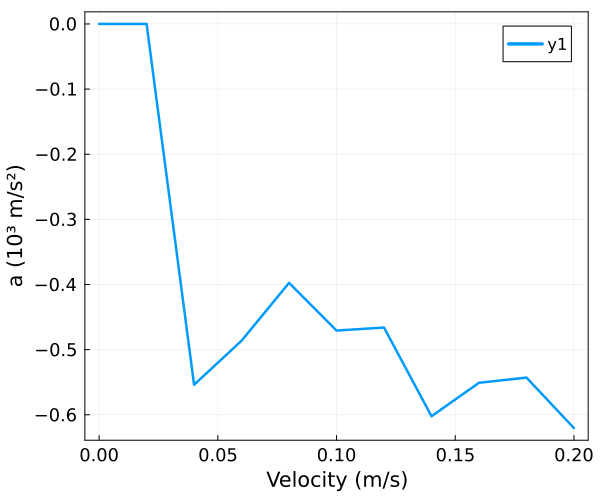

In [27]:
@time scan_params, forces, populations_velocity = force_scan(prob, scan_values, prob_func!, param_func, output_func)
vs, averaged_forces_velocity, stddev_velocity = average_values(scan_params, forces)
plot(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-8,6),
    size=(600,500)
    )

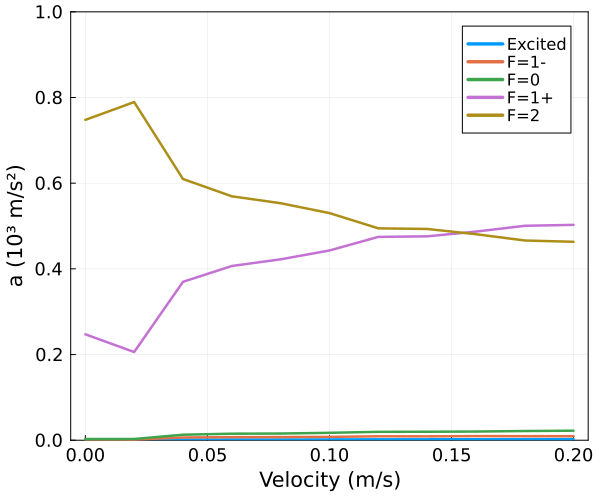

In [28]:
vs, averaged_populations_velocity = average_values(scan_params, populations_velocity)
plot(vs .* (Γ / k), sum(averaged_populations_velocity[:,13:16], dims=2), 
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(0,1),
    size=(600,500),
    label="Excited"
    )
plot!(vs .* (Γ / k), sum(averaged_populations_velocity[:,1:3], dims=2), linewidth=2.5, label="F=1-")
plot!(vs .* (Γ / k), sum(averaged_populations_velocity[:,4], dims=2), linewidth=2.5, label="F=0")
plot!(vs .* (Γ / k), sum(averaged_populations_velocity[:,5:7], dims=2), linewidth=2.5, label="F=1+")
plot!(vs .* (Γ / k), sum(averaged_populations_velocity[:,8:12], dims=2), linewidth=2.5, label="F=2")

In [29]:
Γ .* sum(averaged_populations_velocity[:,13:16], dims=2)

11×1 Matrix{Float64}:
  15476.307905542792
  16669.269930127164
  72018.74433970495
  82434.74254676457
  81804.63212226366
  96215.25577297564
 110611.25309641327
 113081.5296207628
 118046.25591090682
 125729.26699225171
 130133.7477956896